# REINFORCE_Pong_Hard

---

In this notebook, we will train REINFORCE with OpenAI Gym's Pong environment.

sauce: 
- https://github.com/Rafael1s/Deep-Reinforcement-Learning-Udacity
- https://github.com/tnakae/Udacity-DeepRL-PPO/blob/master/pong-REINFORCE.ipynb
- https://github.com/kurohi/deepreinforcement-udacity/tree/master/pong-reinforce
- https://github.com/dolhana/udacity-deep-reinforcement-learning/blob/master/pong/pong-REINFORCE.ipynb
- https://github.com/cwiz/Reinforcement_Learning-Policy_Gradients-2019/blob/master/pong-REINFORCE.ipynb
- https://github.com/a-windisch/deep_reinforcement_learning_play_pong

In [1]:
# install necessary packages
!pip install cloudpickle
!pip install JSAnimation
!pip install progressbar

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Import Packages

In [2]:
%matplotlib inline
from parallelEnv import parallelEnv

import sys, time
import gym

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import progressbar as pb
import random as rand

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from collections  import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
def check_gpu():
    print(f'gpu available: {torch.cuda.is_available()}')
    print(f'gpu count: {torch.cuda.device_count()}')
    print(f'gpu:')
    for no, i in enumerate(range(torch.cuda.device_count())):
        print(f'  {no}: {torch.cuda.get_device_name(i)}')

check_gpu()

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gpu available: True
gpu count: 1
gpu:
  0: TITAN V


In [4]:
# render ai gym environment

# PongDeterministic does not contain random frameskip so is faster to train than the vanilla Pong-v4 environment
env = gym.make('Pong-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [5]:
# the actions are hard-coded below
RIGHT = 4
LEFT = 5

# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel

In [6]:
# preprocess a single frame
# crop image and downsample to 80x80, stack two frames together as input
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

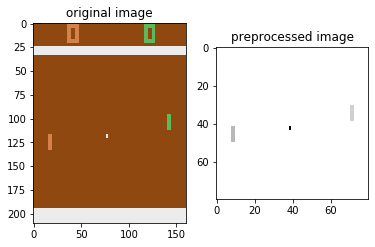

In [7]:
# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [8]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        # new_size = (size - kernel_size)/stride + 1, i.e. (80 - 6)/2 + 1 = 38
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        # new_size = (size - kernel_size)/stride + 1, i.e. (38 - 6)/4 + 1 = 9
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    
policy= Policy().to(device)

# we use the adam optimizer with learning rate 2e-4; optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [9]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list

In [10]:
envs = parallelEnv('PongDeterministic-v4', n=8, seed=0)
prob, state, action, reward = collect_trajectories(envs, policy, tmax=100)

In [11]:
print(reward)

[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

#### Hyperparameter Setting

In [12]:
# training loop max iterations
episode = 2300 # 2000

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# model hyperparameter
discount_rate = .99
beta = .01 
tmax = 300 # 320-400 adviced

#### Training Loop

In [13]:
# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)

    
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [14]:
# keep track of progress
mean_rewards = []
scores_deque = deque(maxlen=100)

# progress bar
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

for e in range(episode):
    
    # collect trajectories
    old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
    
    # discount the rewards
#     rewards = discounted_future_rewards(rewards, ratio=0.999)
    
    # get total rewards
    total_rewards = np.sum(rewards, axis=0)

    scores_deque.append(total_rewards)
    
    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta) # minus because default in pytorch in gradient descent, we wanted gradient ascent here
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces, this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 100 iterations
    if (e+1)%100 ==0 :
        print("Episode: {}, \tscore: {:.2f} \tAverage Score: {:.2f}" \
               .format(e+1, np.mean(total_rewards), np.mean(scores_deque)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 100, 	score: -12.88 	Average Score: -13.24
[-10. -15.  -9. -11. -15. -13. -15. -15.]


Episode: 200, 	score: -13.62 	Average Score: -13.08
[-12. -13. -11. -15. -15. -14. -15. -14.]


Episode: 300, 	score: -12.38 	Average Score: -13.16
[-14. -13. -12. -15. -14. -14.  -9.  -8.]


Episode: 400, 	score: -12.75 	Average Score: -12.65
[-16. -14.  -8. -14. -13.  -8. -15. -14.]


Episode: 500, 	score: -10.88 	Average Score: -12.09
[-11.  -8. -14. -12.  -8. -10. -13. -11.]


Episode: 600, 	score: -10.75 	Average Score: -11.24
[-13.  -9. -14.  -7. -13. -13. -11.  -6.]


Episode: 700, 	score: -8.75 	Average Score: -10.12
[ -9.  -7. -11. -10. -12.  -8.  -8.  -5.]


Episode: 800, 	score: -7.50 	Average Score: -8.95
[ -8. -12.  -7.  -2.  -6.  -7.  -9.  -9.]


Episode: 900, 	score: -5.75 	Average Score: -6.64
[-8. -7. -7. -3. -6. -4. -5. -6.]


Episode: 1000, 	score: -2.88 	Average Score: -3.61
[ 0. -8. -2. -1. -6.  0.  0. -6.]


Episode: 1100, 	score: -1.25 	Average Score: -1.45
[ 0.  0. -1.  0. -4. -3. -2.  0.]


Episode: 1200, 	score: -0.38 	Average Score: -0.75
[ 0.  1.  0.  0. -5.  0.  0.  1.]


Episode: 1300, 	score: 0.00 	Average Score: -0.38
[0. 0. 0. 0. 0. 0. 0. 0.]


Episode: 1400, 	score: -0.12 	Average Score: -0.28
[ 1.  0. -2.  0.  0.  0.  0.  0.]


Episode: 1500, 	score: -0.75 	Average Score: -0.32
[-1.  0.  1.  0. -1.  1. -4. -2.]


Episode: 1600, 	score: -0.75 	Average Score: -0.41
[ 0.  0. -1.  1. -5. -1. -1.  1.]


Episode: 1700, 	score: 1.12 	Average Score: 0.17
[2. 1. 1. 1. 1. 1. 1. 1.]


Episode: 1800, 	score: 0.88 	Average Score: 0.61
[ 1.  1.  1.  1. -2.  1.  2.  2.]


Episode: 1900, 	score: 0.50 	Average Score: 0.74
[ 1.  1.  1.  1. -3.  1.  1.  1.]


Episode: 2000, 	score: 0.62 	Average Score: 0.85
[ 1.  1. -3.  2.  1.  1.  1.  1.]


Episode: 2100, 	score: 1.00 	Average Score: 0.93
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 2200, 	score: 1.00 	Average Score: 0.95
[1. 1. 1. 1. 1. 1. 1. 1.]


Episode: 2300, 	score: 1.00 	Average Score: 0.97
[1. 1. 1. 1. 1. 1. 1. 1.]


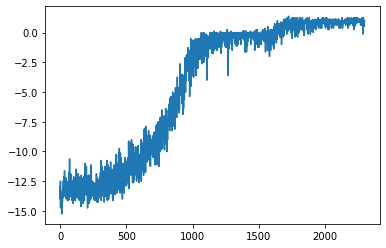

In [15]:
# plot mean rewards
plt.plot(mean_rewards)

In [16]:
# save agent
# torch.save(model.state_dict(), 'surrogate_00003.policy')
# torch.save(model.state_dict(), 'surrogate_clipped_00002.policy')

## Additional Notes

- The performance for the REINFORCE version may be poor. You can try training with a smaller tmax=100 and more number of episodes=2000 to see concrete results.
- Try normalizing your future rewards over all the parallel agents, it can speed up training
- Simpler networks might perform better than more complicated ones! The original input contains 80x80x2=12800 numbers, you might want to ensure that this number steadily decreases at each layer of the neural net.
- Training performance may be significantly worse on local machines. I had worse performance training on my own windows desktop with a 4-core CPU and a GPU. This may be due to the slightly different ways the emulator is rendered. So please run the code on the workspace first before moving locally
- It may be beneficial to train multiple epochs, say first using a small tmax=200 with 500 episodes, and then train again with tmax = 400 with 500 episodes, and then finally with a even larger tmax.
- Remember to save your policy after training!
- for a challenge, try the 'Pong-v4' environment, this includes random frameskips and takes longer to train.